модель определяет был ли текст сгенериран gpt-2

In [1]:
!pip install torch transformers requests huggingface_hub[hf_xet]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 MB 33.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-10.

In [2]:
import os
import json
import pandas as pd
import requests
import torch
from tqdm import tqdm

os.makedirs('gpt2_dataset', exist_ok=True)
os.chdir('gpt2_dataset')

human_url = 'https://openaipublic.azureedge.net/gpt-2/output-dataset/v1/webtext.train.jsonl'
gpt2_url = 'https://openaipublic.azureedge.net/gpt-2/output-dataset/v1/small-117M.train.jsonl'

def download_file(url, filename):
    response = requests.get(url, stream=True)
    response.raise_for_status()

    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024

    with open(filename, 'wb') as f, tqdm(
        desc=filename,
        total=total_size,
        unit='iB',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in response.iter_content(block_size):
            bar.update(len(data))
            f.write(data)

print("Скачивание human texts...")
download_file(human_url, 'webtext.train.jsonl')

print("\nСкачивание GPT-2 texts...")
download_file(gpt2_url, 'gpt-2.train.jsonl')

print("\nЗагрузка завершена!")

Скачивание human texts...


webtext.train.jsonl: 100%|██████████| 648M/648M [04:11<00:00, 2.70MiB/s]



Скачивание GPT-2 texts...


gpt-2.train.jsonl: 100%|██████████| 740M/740M [05:05<00:00, 2.54MiB/s]


Загрузка завершена!


In [3]:
def load_jsonl(file_path, max_samples=50000):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i >= max_samples:
                break
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError:
                continue
    return data

print("Загрузка human texts...")
human_data = load_jsonl('webtext.train.jsonl')

print("Загрузка GPT-2 texts...")
gpt2_data = load_jsonl('gpt-2.train.jsonl')

df_human = pd.DataFrame({
    'text': [item['text'] for item in human_data],
    'label': 0  # 0 = человеческий текст
})

df_gpt2 = pd.DataFrame({
    'text': [item['text'] for item in gpt2_data],
    'label': 1  # 1 = GPT-2 текст
})

df = pd.concat([df_human, df_gpt2], ignore_index=True)

df = df.dropna()
df = df.drop_duplicates(subset=['text'])

print(f"Человеческих текстов: {len(df_human)}")
print(f"GPT-2 текстов: {len(df_gpt2)}")

if len(df_human) == 0 or len(df_gpt2) == 0:
    raise ValueError("Один из датасетов пуст. Проверьте загрузку файлов.")

min_samples = min(len(df_human), len(df_gpt2))

if len(df_human) > len(df_gpt2):
    df_human = df_human.sample(n=min_samples, random_state=42)
else:
    df_gpt2 = df_gpt2.sample(n=min_samples, random_state=42)

df = pd.concat([df_human, df_gpt2], ignore_index=True)

print(f"\nИтоговый размер датасета: {len(df)} примеров")
print(df['label'].value_counts())

df.to_csv('processed_dataset.csv', index=False)

print(f"\nИтоговый размер датасета: {len(df)} примеров")
print(df['label'].value_counts())

Загрузка human texts...
Загрузка GPT-2 texts...
Человеческих текстов: 50000
GPT-2 текстов: 50000

Итоговый размер датасета: 100000 примеров
label
0    50000
1    50000
Name: count, dtype: int64

Итоговый размер датасета: 100000 примеров
label
0    50000
1    50000
Name: count, dtype: int64


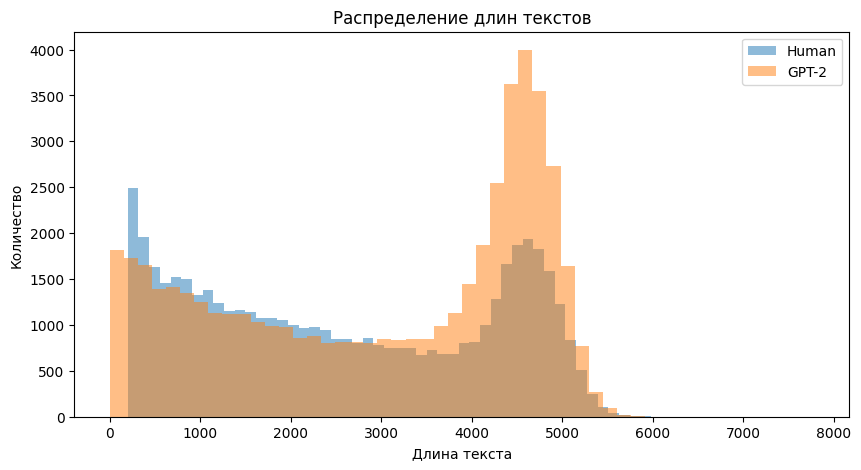


Пример человеческого текста:
These girlfriends deserves a special mention for going that extra mile, hopefully doesn't set too many guys off on the path towards outrageous demands.

1. She knows the severity of man-flu

2. All fun and games is all good

3. A voucher that says 'I love you'

4. When arguments don't drag on forever.

5. Providing everything he needs.

6. Very understanding

7. As awesome a gesture as this is, we are worried about this man's cooking skills.

8. Nice cake

8. Fair bargaining

9. Excellent gift c...

Пример GPT-2 текста:
Video: Video: HOW SHUKK PINGES WORKING: He's the only one who can come up with a clever yet difficult combination or have he best be 'abstract filler'


Lola Kirke WatchESPN Juliet Huddy Carl Edwards Jordan Hankins Ty Pozzobon Death Tree Man NFL mock draft Altaba Obama Farewell Speech Pioneer Cabin tree Raymond James Stadium Alabama Vs Clemson Clemson Tigers Rodeo Houston 2017

Browser not supported.

Please update to Chrome / Firefox.

Als

In [4]:
import matplotlib.pyplot as plt

df['text_length'] = df['text'].str.len()
plt.figure(figsize=(10, 5))
plt.hist(df[df['label']==0]['text_length'], bins=50, alpha=0.5, label='Human')
plt.hist(df[df['label']==1]['text_length'], bins=50, alpha=0.5, label='GPT-2')
plt.title('Распределение длин текстов')
plt.xlabel('Длина текста')
plt.ylabel('Количество')
plt.legend()
plt.show()

print("\nПример человеческого текста:")
print(df[df['label']==0]['text'].iloc[0][:500] + "...")

print("\nПример GPT-2 текста:")
print(df[df['label']==1]['text'].iloc[0][:500] + "...")

In [5]:
from transformers import BertTokenizer
from torch.utils.data import Dataset

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts  # Список текстов
        self.labels = labels  # Список меток
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label)
        }

dataset = TextDataset(
    texts=df["text"].values,
    labels=df["label"].values,
    tokenizer=tokenizer
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [6]:
text = "The cat sat on the mat."
encoding = tokenizer(
    text,
    max_length=10,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)

print(encoding)

{'input_ids': tensor([[  101,  1996,  4937,  2938,  2006,  1996, 13523,  1012,   102,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0]])}


In [7]:
from torch.utils.data import Dataset, Subset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split

def stratified_random_split(dataset: TextDataset, test_size: float = 0.2, random_state: int = 42):

    labels = dataset.labels

    train_indices, val_indices = train_test_split(
        np.arange(len(dataset)),
        test_size=test_size,
        stratify=labels,
        random_state=random_state
    )

    train_dataset = TextDataset(
        texts=dataset.texts[train_indices],
        labels=dataset.labels[train_indices],
        tokenizer=dataset.tokenizer,
        max_len=dataset.max_len
    )
    
    val_dataset = TextDataset(
        texts=dataset.texts[val_indices],
        labels=dataset.labels[val_indices],
        tokenizer=dataset.tokenizer,
        max_len=dataset.max_len
    )
    
    return train_dataset, val_dataset

In [8]:
train_dataset, val_dataset = stratified_random_split(dataset, test_size=0.2)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

print("Train распределение:", np.bincount(train_dataset.labels))
print("Val распределение:", np.bincount(val_dataset.labels))

Train распределение: [40000 40000]
Val распределение: [10000 10000]


In [9]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,  # 2 класса: human/gpt-2
    output_attentions=False,
    output_hidden_states=False
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

2025-05-11 12:17:05.783507: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746965825.948351      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746965826.002507      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [10]:
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW

epochs = 3
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [11]:
from tqdm import tqdm
import numpy as np

def train():
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_loss = total_loss / len(train_loader)
    return avg_loss

In [12]:
from sklearn.metrics import accuracy_score, f1_score

def evaluate():
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            preds = torch.argmax(logits, dim=1).flatten()
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    return accuracy, f1


Epoch 1/3


100%|██████████| 5000/5000 [1:23:37<00:00,  1.00s/it]


Train Loss: 0.1600
Val Accuracy: 0.9247 | Val F1: 0.9192

Epoch 2/3


100%|██████████| 5000/5000 [1:23:47<00:00,  1.01s/it]


Train Loss: 0.0640
Val Accuracy: 0.9397 | Val F1: 0.9364

Epoch 3/3


100%|██████████| 5000/5000 [1:23:47<00:00,  1.01s/it]


Train Loss: 0.0194
Val Accuracy: 0.9525 | Val F1: 0.9506


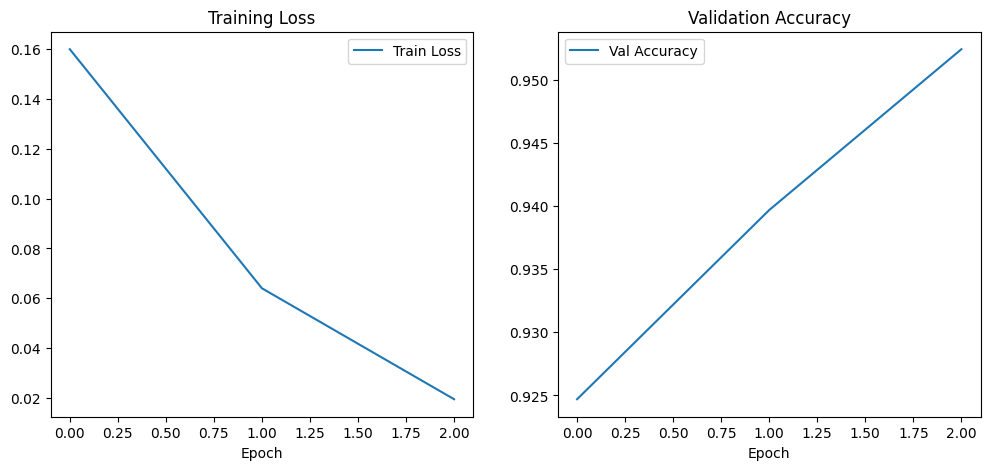

In [13]:
import matplotlib.pyplot as plt
train_losses = []
val_accuracies = []
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    train_loss = train()
    val_accuracy, val_f1 = evaluate()

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Accuracy: {val_accuracy:.4f} | Val F1: {val_f1:.4f}")
    train_losses.append(train_loss)
    val_accuracies.append(val_accuracy)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [14]:
def predict(text):
    inputs = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    probs = torch.softmax(outputs.logits, dim=1)
    return probs[0][1].item()  # Вероятность, что текст от GPT-2

text = "The quantum theory of gravity remains unsolved..."
print(f"Вероятность генерации GPT-2: {predict(text):.2%}")

Вероятность генерации GPT-2: 99.94%


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

train_texts = [tokenizer.decode(train_dataset[i]['input_ids'].tolist()) for i in range(len(train_dataset))]
val_texts = [tokenizer.decode(val_dataset[i]['input_ids'].tolist()) for i in range(len(val_dataset))]

train_labels = [train_dataset.labels[i] for i in range(len(train_dataset))]
val_labels = [val_dataset.labels[i] for i in range(len(val_dataset))]

tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(train_texts)
X_val_tfidf = tfidf.transform(val_texts)

In [16]:
print("Распределение классов в train:", np.bincount(train_labels))
print("Распределение классов в val:", np.bincount(val_labels))

Распределение классов в train: [40000 40000]
Распределение классов в val: [10000 10000]


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)


param_grid = [
    {
        'solver': ['newton-cg', 'lbfgs', 'sag'],
        'penalty': ['l2'],
        'C': [0.1, 1, 10]
    },
    {
        'solver': ['liblinear'],
        'penalty': ['l1', 'l2'],
        'C': [0.1, 1, 10]
    },
    {
        'solver': ['saga'],
        'penalty': ['elasticnet'],
        'C': [0.001, 0.01, 0.1],
        'l1_ratio': [0.5, 0.7, 0.9]
    }
]

grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid,
    cv=5,
    scoring='accuracy',
    error_score=np.nan,
    n_jobs=-1
)
grid_search.fit(X_train_tfidf, train_labels)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая accuracy при обучении:", grid_search.best_score_)


best_clf = grid_search.best_estimator_
preds = best_clf.predict(X_val_tfidf)

print(f"Лучшая Accuracy на тесте: {accuracy_score(val_labels, preds):.4f}")



print("\n=== Основные метрики ===")
print(f"Accuracy:  {accuracy_score(val_labels, preds):.4f}")  # Доля правильных ответов
print(f"Precision: {precision_score(val_labels, preds, average='macro'):.4f}")  # Точность (для каждого класса)
print(f"Recall:    {recall_score(val_labels, preds, average='macro'):.4f}")  # Полнота (для каждого класса)
print(f"F1-score:  {f1_score(val_labels, preds, average='macro'):.4f}")  # Гармоническое среднее precision и recall

Лучшие параметры: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Лучшая accuracy при обучении: 0.7545375
Лучшая Accuracy на тесте: 0.7601

=== Основные метрики ===
Accuracy:  0.7601
Precision: 0.7718
Recall:    0.7601
F1-score:  0.7576


In [18]:
preds1 = []

for text in val_texts:
    prob = predict(text)  
    preds1.append(prob)   

pred_labels1 = [1 if prob > 0.5 else 0 for prob in preds1]

print("\n=== Основные метрики ===")
print(f"Accuracy:  {accuracy_score(val_labels, pred_labels1):.4f}") 
print(f"Precision: {precision_score(val_labels, pred_labels1, average='macro'):.4f}")
print(f"Recall:    {recall_score(val_labels, pred_labels1, average='macro'):.4f}")
print(f"F1-score:  {f1_score(val_labels, pred_labels1, average='macro'):.4f}")

print("\n=== Classification Report ===")
print(classification_report(val_labels, pred_labels1))  


=== Основные метрики ===
Accuracy:  0.9345
Precision: 0.9346
Recall:    0.9345
F1-score:  0.9345

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.94      0.93      0.93     10000
           1       0.93      0.94      0.93     10000

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000



In [19]:
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    f1_score,
)

bert_metrics = {
    'accuracy': accuracy_score(val_labels, pred_labels1),
    'f1': f1_score(val_labels, pred_labels1, average='weighted'),
    'recall': recall_score(val_labels, pred_labels1, average='weighted'),
}


lr_metrics = {
    'accuracy': accuracy_score(val_labels, preds),
    'f1': f1_score(val_labels, preds, average='weighted'),
    'recall': recall_score(val_labels, preds, average='weighted')
}


comparison = pd.DataFrame({
    'BERT': bert_metrics,
    'Logistic Regression': lr_metrics,
}).T

print(comparison)

                     accuracy       f1   recall
BERT                  0.93455  0.93455  0.93455
Logistic Regression   0.76015  0.75755  0.76015


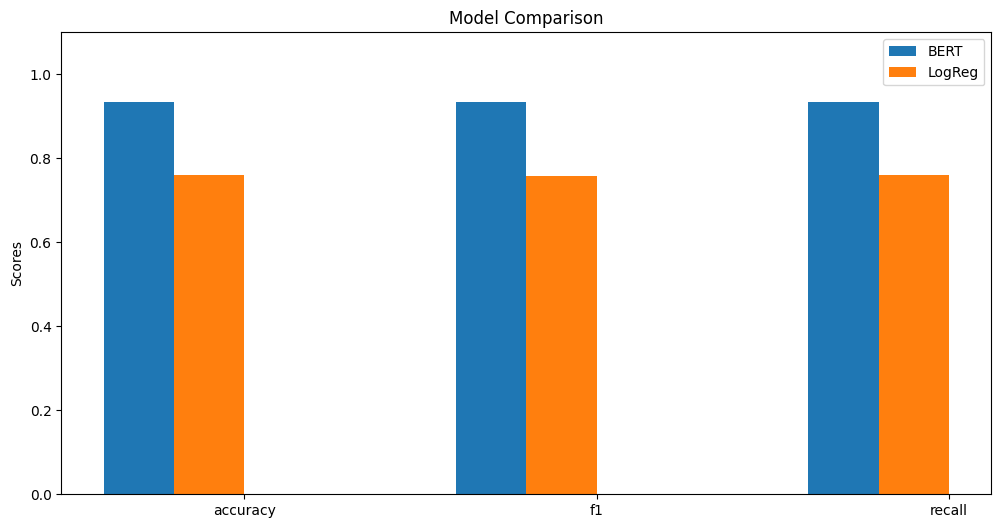

In [20]:
import matplotlib.pyplot as plt

metrics = ['accuracy', 'f1', 'recall']
x = range(len(metrics))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x, [bert_metrics[m] for m in metrics], width, label='BERT')
ax.bar([p + width for p in x], [lr_metrics[m] for m in metrics], width, label='LogReg')

ax.set_ylabel('Scores')
ax.set_title('Model Comparison')
ax.set_xticks([p + 1.5*width for p in x])
ax.set_xticklabels(metrics)
ax.legend()
plt.ylim(0, 1.1)
plt.show()

возможные улучшения:

Добавление шумов в реальные тексты (опечатки, синонимы).
Комбинация BERT + статистические методы (перплексия).
